In [ ]:
import re

def clean_text_spacing(text):
    text = re.sub(r'(?<=[.!?])(?=\w)', r' ', text)
    text = re.sub(r'(?<=[.,!?;:])(?=\S)', r' ', text)
    return text

def split_into_sentences(text):
    sentence_endings = re.compile(r'(?<=[.!?])\s+(?=[A-Z])')
    return sentence_endings.split(text)

# 1st cell from the transcripts csv file for sample
text_test = open("sample.txt").read()
cleaned_text = clean_text_spacing(text_test)
sentences = split_into_sentences(cleaned_text)

for i, sentence in enumerate(sentences, 1):
    print(f"{i}. {sentence}")


In [ ]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2') #smaller models are not as accurate

In [ ]:
s1 = "I rarely walk."
s2 = "Once in a blue moon, I walk."
s3 = "I walked on a blue moon once"

# Get embeddings
embeddings = model.encode([s1, s2, s3], convert_to_tensor=True)

# Compute pairwise cosine similarity
similarity_1_2 = util.pytorch_cos_sim(embeddings[0], embeddings[1]).item()
similarity_1_3 = util.pytorch_cos_sim(embeddings[0], embeddings[2]).item()

# Print results
print(f"Similarity between idiom and meaning (rarely walk): {similarity_1_2:.4f}")
print(f"Similarity between literal blue moon and rarely walk: {similarity_1_3:.4f}")

Similarity between idiom and meaning (rarely walk): 0.6976
Similarity between literal blue moon and rarely walk: 0.3613


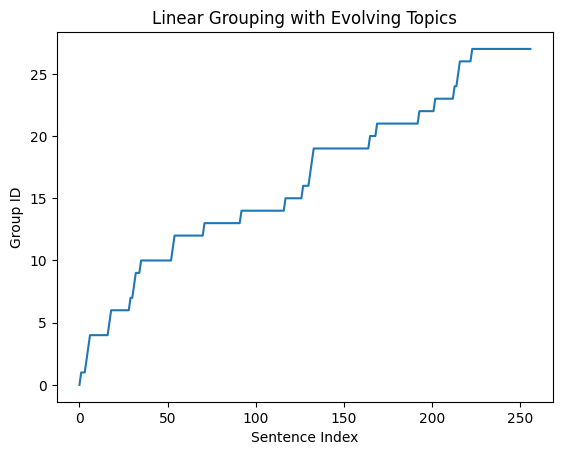

Sentence Groups (dynamic threshold from 0.65 with decay=0):

Group 1:
  - Thank you so much, Neha, for what a wonderful introduction.
  - Nothing fills me with more hope than when I hear incredible young people like Neha and all the outstanding work that she’s doing on behalf of India’s youth and for representing this nation’s energy and its optimism and its idealism.
  - She makes me very, very proud.
  - Because we just had a chance to meet, and she’s beaming with pride right now sitting next to you.
  - Give Neha a big round of applause once again.
  - Distinguished guests, ladies and gentlemen, to all the students and young people who are here today, to the people of India watching and listening across this vast nation.
  - I bring the friendship and the greetings of the American people.
  - On behalf of myself and Michelle, thank you so much for welcoming us back to India.
  - Bahoot dhanyavad.
  - It has been a great honor to be the first American President to join you for Republ

In [ ]:
import torch
from sentence_transformers import util
import matplotlib.pyplot as plt
new = [0]
def linear_grouping(sentences, model, base_threshold=0.65, decay_rate=0):
    embeddings = model.encode(sentences, convert_to_tensor=True)
    n = len(sentences)

    groups = []
    group_averages = []


    for i in range(n):
        if i == 0:
            groups.append([i])
            group_averages.append(embeddings[i])
            continue

        best_group_idx = None
        best_sim = -1
        current_threshold = base_threshold - i * decay_rate

        for idx, avg_embedding in enumerate(group_averages):
            sim = util.pytorch_cos_sim(embeddings[i], avg_embedding).item()
            sim = (sim + 1) / 2  # Normalize to [0, 1]

            if sim > best_sim:
                best_sim = sim
                best_group_idx = idx

        if best_sim >= current_threshold:
            groups[best_group_idx].append(i)
            group_averages[best_group_idx] = torch.mean(embeddings[groups[best_group_idx]], dim=0)
            new.append(new[-1])
        else:
            groups.append([i])
            group_averages.append(embeddings[i])
            new.append(new[-1] + 1)

    # Plotting
    plt.plot(new)
    plt.xlabel("Sentence Index")
    plt.ylabel("Group ID")
    plt.title("Linear Grouping with Evolving Topics")
    plt.show()

    # Output grouped sentences
    print(f"Sentence Groups (dynamic threshold from {base_threshold} with decay={decay_rate}):\n")
    for idx, group in enumerate(groups, 1):
        print(f"Group {idx}:")
        for sent_idx in group:
            print(f"  - {sentences[sent_idx]}")

linear_grouping(sentences, model)
print(new)

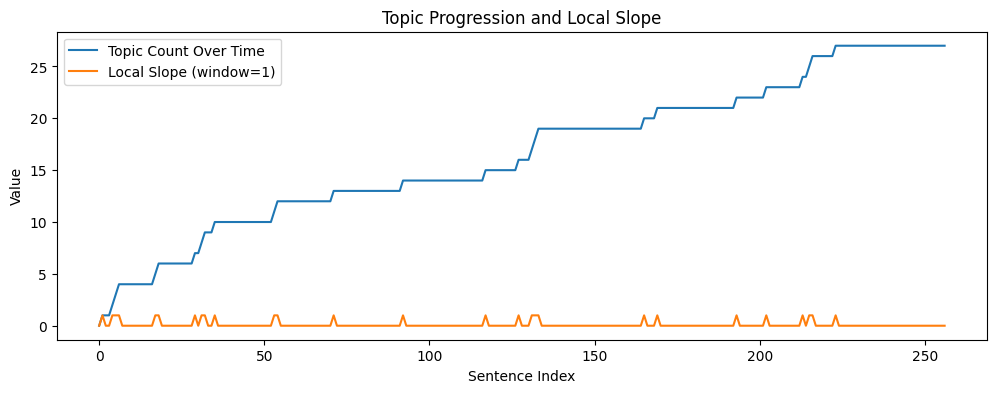

Speech saturation likely reached around sentence index: 0


0

In [ ]:
def moving_slope(data, window=1):
    slopes = []
    for i in range(len(data)):
        if i < window:
            slopes.append(0)
        else:
            dy = data[i] - data[i - window]
            dx = window
            slopes.append(dy / dx)
    return slopes

def global_slope(data):
    return (data[-1] - data[0]) / len(data)

def estimate_progress(data, window=1):
    local = moving_slope(data, window)
    global_ = global_slope(data)
    normalized_local = local

    for i, val in enumerate(normalized_local):
        if val < 0.5:
            print(f"Speech saturation likely reached around sentence index: {i}")
            return i
    print("Speech likely did not reach saturation.")
    return len(data)

def plot_slopes(data, window=1):
    local = moving_slope(data, window)
    plt.figure(figsize=(12, 4))
    plt.plot(data, label='Topic Count Over Time')
    plt.plot(local, label=f'Local Slope (window={window})')
    plt.xlabel("Sentence Index")
    plt.ylabel("Value")
    plt.title("Topic Progression and Local Slope")
    plt.legend()
    plt.show()

plot_slopes(new)
estimate_progress(new)

In [ ]:
import torch
from sentence_transformers import util
import matplotlib.pyplot as plt
new = [0]

def linear_grouping(sentences, model, initial_threshold=0.65, decay_rate=0.01, min_threshold=0.4):
    """
    Modified version with length-weighted embeddings.
    Longer sentences contribute more to group embeddings.
    """
    embeddings = []
    sentence_lengths = []  # Store token counts for each sentence
    groups = []
    group_embeddings = []
    group_weights = []  # Track total weight for each group
    threshold_history = []
    group_counts = []

    for i, sentence in enumerate(sentences):
        # Step 1: Embed the new sentence and get its length weight
        new_embedding = model.encode(sentence, convert_to_tensor=True)
        length_weight = len(sentence.split())  # Use word count as weight
        embeddings.append(new_embedding)
        sentence_lengths.append(length_weight)

        # Step 2: Initialize first group
        if i == 0:
            groups.append([0])
            group_embeddings.append(new_embedding)
            group_weights.append(length_weight)
            threshold_history.append(0.7 if initial_threshold is None else initial_threshold)
            group_counts.append(1)
            continue

        current_threshold = threshold_history[-1]

        # Step 3: Find best-matching existing group (with weighted comparison)
        best_sim = -1
        best_group = None
        for group_idx, (group_embed, group_weight) in enumerate(zip(group_embeddings, group_weights)):
            # Weighted similarity comparison
            sim = util.pytorch_cos_sim(new_embedding, group_embed).item()
            if sim > best_sim:
                best_sim = sim
                best_group = group_idx

        # Step 4: Assign to group or create new one
        if best_sim >= current_threshold:
            groups[best_group].append(i)

            # Update group embedding with weighted average
            group_indices = groups[best_group]
            weights = torch.tensor([sentence_lengths[idx] for idx in group_indices],
                                 device=new_embedding.device)
            stacked_embeddings = torch.stack([embeddings[idx] for idx in group_indices])

            # Weighted mean calculation
            group_embeddings[best_group] = torch.sum(
                stacked_embeddings * weights.view(-1, 1), dim=0
            ) / torch.sum(weights)

            group_weights[best_group] += length_weight
            new_threshold = current_threshold * (1 - decay_rate/5)
        else:
            groups.append([i])
            group_embeddings.append(new_embedding)
            group_weights.append(length_weight)
            new_threshold = max(min_threshold, current_threshold - decay_rate)

        threshold_history.append(new_threshold)
        group_counts.append(len(groups))

    # [Rest of your plotting/output code remains the same]
    # Plotting
    plt.figure(figsize=(10, 4))
    plt.plot(threshold_history, label='Dynamic Threshold')
    plt.plot(group_counts, label='Number of Groups')
    plt.xlabel("Sentence Index")
    plt.title("Real-Time Topic Grouping")
    plt.legend()
    plt.show()

    # Print results
    print(f"Final Groups (min_threshold={min_threshold:.2f}, decay_rate={decay_rate:.3f}):")
    for idx, group in enumerate(groups):
        print(f"\nGroup {idx + 1}:")
        for sent_idx in group:
            print(f"  - {sentences[sent_idx]}")

linear_grouping(sentences, sentModel)
print(new)

In [ ]:
import re
import numpy as np
import torch
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import DBSCAN
from scipy.spatial import distance
from collections import deque

# Text preprocessing functions
def clean_text_spacing(text):
    text = re.sub(r'(?<=[.!?])(?=\w)', r' ', text)
    text = re.sub(r'(?<=[.,!?;:])(?=\S)', r' ', text)
    return text

def split_into_sentences(text):
    sentence_endings = re.compile(r'(?<=[.!?])\s+(?=[A-Z])')
    return sentence_endings.split(text)

# Load sample text
text_test = open("sample.txt").read()
cleaned_text = clean_text_spacing(text_test)
sentences = split_into_sentences(cleaned_text)

# Initialize model
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

# Topic tracking and novelty detection system
class TopicTracker:
    def __init__(self, novelty_decay=0.2, staleness_threshold=0.65):
        self.topics = {}  # topic_id: {'centroid', 'last_seen', 'count'}
        self.next_topic_id = 0
        self.novelty_decay = novelty_decay
        self.staleness_threshold = staleness_threshold
        self.novelty_history = deque(maxlen=10)
        self.staleness_history = deque(maxlen=10)

    def update_topics(self, batch_embeddings):
        """Cluster sentences and update topic registry"""
        # Convert to numpy for clustering
        embeddings_np = batch_embeddings.cpu().numpy() if isinstance(batch_embeddings, torch.Tensor) else batch_embeddings

        # Cluster using DBSCAN
        clustering = DBSCAN(eps=0.4, min_samples=1, metric='cosine').fit(embeddings_np)
        labels = clustering.labels_

        # Process clusters
        batch_topics = {}
        for label in set(labels):
            if label == -1:  # Handle noise as individual topics
                for i in np.where(labels == label)[0]:
                    topic_centroid = embeddings_np[i]
                    topic_id = self._match_or_create_topic(topic_centroid)
                    batch_topics[topic_id] = batch_topics.get(topic_id, []) + [i]
            else:
                indices = np.where(labels == label)[0]
                topic_centroid = np.mean(embeddings_np[indices], axis=0)
                topic_id = self._match_or_create_topic(topic_centroid)
                batch_topics[topic_id] = batch_topics.get(topic_id, []) + list(indices)

        return batch_topics

    def _match_or_create_topic(self, centroid):
        """Match to existing topic or create new one"""
        best_match = None
        best_sim = -1

        for topic_id, topic_data in self.topics.items():
            sim = 1 - distance.cosine(centroid, topic_data['centroid'])
            if sim > best_sim:
                best_sim = sim
                best_match = topic_id

        # Update existing topic or create new
        if best_sim > self.staleness_threshold:
            self.topics[best_match]['centroid'] = (
                self.topics[best_match]['centroid'] + centroid
            ) / 2
            self.topics[best_match]['count'] += 1
            self.topics[best_match]['last_seen'] = len(self.novelty_history)
            return best_match
        else:
            self.topics[self.next_topic_id] = {
                'centroid': centroid,
                'last_seen': len(self.novelty_history),
                'count': 1
            }
            self.next_topic_id += 1
            return self.next_topic_id - 1

    def calculate_novelty(self, batch_topics):
        """Calculate novelty score for current batch"""
        if not batch_topics:
            return 0.0

        novelty = 0
        for topic_id in batch_topics:
            topic_data = self.topics[topic_id]
            # Calculate decay based on how many batches since last seen
            if 'last_seen' in topic_data:
                batches_ago = len(self.novelty_history) - topic_data['last_seen']
                decay_factor = np.exp(-self.novelty_decay * batches_ago)
            else:
                decay_factor = 1.0  # New topic

            # Higher novelty for topics seen fewer times
            novelty += decay_factor / (topic_data['count'] ** 0.5)

        # Normalize by number of topics
        normalized_novelty = novelty / len(batch_topics)
        self.novelty_history.append(normalized_novelty)
        return normalized_novelty

    def calculate_staleness(self):
        """Calculate staleness based on novelty trend"""
        if len(self.novelty_history) < 3:
            return 0.0

        # Calculate trend of last 3 novelty scores
        recent_novelty = list(self.novelty_history)[-3:]
        x = np.arange(3)
        slope, _ = np.polyfit(x, recent_novelty, 1)

        # Staleness increases when novelty decreases
        staleness = max(0, -slope * 5)  # Scale slope to [0,1] range
        self.staleness_history.append(staleness)
        return min(1.0, staleness)


    def predict_completion(self, current_batch_index, total_batches, sentences):
        """Predict completion percentage"""
        if len(self.novelty_history) < 3:
            # Not enough data, use position-based estimate
            position_ratio = current_batch_index / total_batches if total_batches > 0 else 0
            return min(90, position_ratio * 100)

        # Position-based completion
        position_ratio = current_batch_index / total_batches

        # Novelty decay factor
        recent_novelty = np.mean(list(self.novelty_history)[-3:])
        initial_novelty = np.mean(list(self.novelty_history)[:3])
        novelty_decay = max(0, 1 - (recent_novelty / initial_novelty)) if initial_novelty > 0 else 0

        # Staleness factor
        staleness = np.mean(self.staleness_history) if self.staleness_history else 0

        # Combine factors with weights
        completion = (
            0.4 * position_ratio +
            0.3 * novelty_decay +
            0.2 * staleness
        )

        return min(99, completion * 100)

# Process text in batches
BATCH_SIZE = 5
tracker = TopicTracker()

print("Processing speech and predicting completion:\n")
print(f"{'Batch':<6} | {'Topics':<6} | {'Novelty':<7} | {'Staleness':<9} | {'Completion':<10} | Status")
print("-" * 70)

for batch_idx in range(0, len(sentences), BATCH_SIZE):
    batch_sentences = sentences[batch_idx:batch_idx+BATCH_SIZE]
    batch_embeddings = model.encode(batch_sentences, convert_to_tensor=True)

    # Update topics and calculate novelty
    batch_topics = tracker.update_topics(batch_embeddings)
    novelty = tracker.calculate_novelty(batch_topics)
    staleness = tracker.calculate_staleness()

    # Predict completion percentage
    completion = tracker.predict_completion(
        batch_idx // BATCH_SIZE,
        len(sentences) // BATCH_SIZE,
        batch_sentences
    )

    # Visual progress bar
    progress_bar = "[" + "=" * int(completion / 5) + " " * (20 - int(completion / 5)) + "]"

    print(f"{batch_idx//BATCH_SIZE+1:<6} | {len(batch_topics):<6} | {novelty:.4f}  | {staleness:.4f}    | {completion:6.1f}%    | {progress_bar}")

    # Early exit if completion is high
    if completion > 95:
        print("\n[!] Speech completion predicted - ending analysis")
        break

# Final topic analysis
print("\nTopic Summary:")
for topic_id, topic_data in tracker.topics.items():
    print(f"Topic {topic_id}: Seen {topic_data['count']} times")

Processing speech and predicting completion:

Batch  | Topics | Novelty | Staleness | Completion | Status
----------------------------------------------------------------------
1      | 5      | 1.0000  | 0.0000    |    0.0%    | [                    ]
2      | 5      | 1.0000  | 0.0000    |    2.0%    | [                    ]
3      | 5      | 1.0000  | 0.0000    |    1.6%    | [                    ]
4      | 5      | 0.9414  | 0.1464    |    4.4%    | [                    ]
5      | 2      | 0.8536  | 0.3661    |    8.6%    | [=                   ]
6      | 5      | 1.0000  | 0.0000    |    8.5%    | [=                   ]
7      | 5      | 1.0000  | 0.0000    |    8.2%    | [=                   ]
8      | 4      | 1.0000  | 0.0000    |    7.2%    | [=                   ]
9      | 3      | 0.9024  | 0.2441    |    9.4%    | [=                   ]
10     | 5      | 1.0000  | 0.0000    |    9.9%    | [=                   ]
11     | 5      | 1.0000  | 0.0000    |    9.9%    | [=        